In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import yfinance as yf
import statsmodels.api as sm

from scipy import stats

import requests
import json
import os
import sys
import time

In [2]:
# Get BTC-USD data
btc = yf.download('BTC-USD', start='2018-01-01', end=datetime.now())
btc_df = pd.DataFrame(btc)

if isinstance(btc_df.columns, pd.MultiIndex):
    btc_df.columns = btc_df.columns.map(lambda col: col[0])
    btc_df['Date'] = pd.to_datetime(btc_df.index)
btc_df.set_index(btc_df.index, inplace=True)
btc_df['Return'] = btc_df['Close'].pct_change()
btc_df['Logreturn'] = np.log(btc_df['Close'] / btc_df['Close'].shift(1))
# Extract closing prices as a series (by close, we take a weighted average of the open, high, low, and close prices)


# Display summary
print(f"Total days: {len(btc_df.index)}")
print(f"Date range: {btc_df.index[0]} to {btc_df.index[-1]}")
print(f"Current price: ${int(btc_df['Close'].iloc[-1]):,.2f}")
print(f"Min price: ${int(btc_df['Close'].min()):,.2f}")
print(f"Max price: ${int(btc_df['Close'].max()):,.2f}")

C:\Users\Viet Long\AppData\Local\Temp\ipykernel_6652\385731745.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2018-01-01', end=datetime.now())
[*********************100%***********************]  1 of 1 completed

Total days: 2873
Date range: 2018-01-01 00:00:00 to 2025-11-13 00:00:00
Current price: $101,841.00
Min price: $3,236.00
Max price: $124,752.00


In [ ]:
def calculate_rolling_cvar(returns, window=365, alpha=0.05):
    """
    Calculate rolling CVaR using historical simulation.
    
    Parameters:
    -----------
    returns : pd.Series
        Log returns series
    window : int
        Rolling window size (default 252 = 1 year of trading days)
    alpha : float
        Confidence level for CVaR (default 0.05 for 5%)
    
    Returns:
    --------
    cvar : float
        CVaR as a negative percentage (e.g., -0.07 means 7% expected loss)
    """
    if len(returns) < window:
        return np.nan
    
    # Use the most recent 'window' returns
    recent_returns = returns[-window:]
    
    # Calculate VaR threshold
    var_threshold = np.percentile(recent_returns, alpha * 100)
    
    # Calculate CVaR (mean of returns at or below VaR)
    cvar = recent_returns[recent_returns <= var_threshold].mean()
    
    return cvar


def cvar_constrained_portfolio_backtest(
    btc_df,
    initial_capital,
    lookback_window,
    target_portfolio_cvar,
    alpha,
    risk_free_rate
):
    """
    Backtest a portfolio strategy that maintains CVaR at target level.
    
    The strategy solves: CVaR_alpha(w * BTC) = target_portfolio_cvar * Portfolio_Value
    Where w is the weight in BTC and (1-w) is in cash.
    
    This simplifies to: w = target_portfolio_cvar / |CVaR|
    
    Parameters:
    -----------
    btc_df : pd.DataFrame
        DataFrame with BTC prices and returns (must have 'Close' and 'Logreturn')
    initial_capital : float
        Starting portfolio value in dollars
    lookback_window : int
        Number of days to use for CVaR estimation
    target_portfolio_cvar : float
        Target CVaR as a fraction of portfolio (e.g., 0.05 = 5%)
    alpha : float
        Confidence level for CVaR calculation (e.g., 0.05 for 5% CVaR)
    risk_free_rate : float
        Daily risk-free rate for cash position
    
    Returns:
    --------
    results_df : pd.DataFrame
        DataFrame with daily portfolio metrics
    """
    
    # Prepare results storage
    results = []
    
    # Initialize portfolio
    portfolio_value = initial_capital
    btc_units = 0  # Number of BTC units held
    cash = initial_capital
    
    # Start after we have enough data for CVaR estimation
    start_idx = lookback_window
    
    for i in range(start_idx, len(btc_df)):
        date = btc_df.index[i]
        btc_price = btc_df['Close'].iloc[i]
        
        # Get historical returns for CVaR calculation
        historical_returns = btc_df['Logreturn'].iloc[i-lookback_window:i].dropna()
        
        if len(historical_returns) < lookback_window * 0.9:  # Allow 10% missing data
            continue
        
        # Calculate CVaR of BTC returns
        btc_cvar = calculate_rolling_cvar(historical_returns, window=lookback_window, alpha=alpha)
        
        if np.isnan(btc_cvar) or btc_cvar >= 0:
            # If CVaR is positive or undefined, something is wrong - use conservative position
            optimal_weight = 0.0
        else:
            # Solve for optimal weight: w = target_CVaR / |CVaR_BTC|
            # Note: btc_cvar is negative, so we take absolute value
            optimal_weight = target_portfolio_cvar / abs(btc_cvar)
            
            # Cap weight at 100% (can't short cash or leverage)
            optimal_weight = min(optimal_weight, 1.0)
            
            # Optional: floor at 0% (can't short BTC in this simple model)
            optimal_weight = max(optimal_weight, 0.0)
        
        # Calculate target positions
        target_btc_value = optimal_weight * portfolio_value
        target_cash_value = (1 - optimal_weight) * portfolio_value
        
        # Rebalance: sell/buy BTC to reach target allocation
        current_btc_value = btc_units * btc_price
        btc_to_trade_value = target_btc_value - current_btc_value
        
        # Execute trade (ignoring transaction costs for now)
        if btc_to_trade_value > 0:
            # Buy BTC with cash
            btc_units += btc_to_trade_value / btc_price
            cash -= btc_to_trade_value
        else:
            # Sell BTC for cash
            btc_units += btc_to_trade_value / btc_price  # negative value
            cash -= btc_to_trade_value  # subtract negative = add
        
        # Apply risk-free rate to cash position
        cash *= (1 + risk_free_rate)
        
        # Calculate portfolio value before next day's returns
        portfolio_value = btc_units * btc_price + cash
        
        # Store results
        results.append({
            'Date': date,
            'BTC_Price': btc_price,
            'BTC_CVaR': btc_cvar,
            'Optimal_Weight': optimal_weight,
            'BTC_Units': btc_units,
            'BTC_Value': btc_units * btc_price,
            'Cash': cash,
            'Portfolio_Value': portfolio_value,
            'Portfolio_Return': (portfolio_value / initial_capital - 1) if i == start_idx else None
        })
        
        # Update portfolio value for next iteration (apply BTC return if next day exists)
        if i < len(btc_df) - 1:
            next_return = btc_df['Logreturn'].iloc[i + 1]
            if not np.isnan(next_return):
                # Update BTC value based on return
                btc_units_next = btc_units * np.exp(next_return)
                portfolio_value = btc_units_next * btc_df['Close'].iloc[i + 1] + cash
                btc_units = btc_units_next
    
    results_df = pd.DataFrame(results)
    results_df['Portfolio_Return'] = results_df['Portfolio_Value'] / initial_capital - 1
    results_df['BTC_Buy_Hold_Return'] = (btc_df['Close'].iloc[start_idx:start_idx+len(results_df)].values / 
                                          btc_df['Close'].iloc[start_idx] - 1)
    
    return results_df

# Run the backtest
initial_capital = 1000000
lookback_window = 365  # 1 year rolling window
target_portfolio_cvar = 0.02  # 2% portfolio 1dCVaR target
alpha = 0.05  # 5% confidence level of BTC CVaR
risk_free_rate = 0.000098  # 0% risk-free rate (or use 0.00010 for ~2.5% annual)

portfolio_results = cvar_constrained_portfolio_backtest(
    btc_df,
    initial_capital,
    lookback_window,
    target_portfolio_cvar,
    alpha,
    risk_free_rate
)

# Display results
print("=" * 80)
print("CVAR-CONSTRAINED PORTFOLIO STRATEGY RESULTS")
print("=" * 80)
print(f"\nInitial Capital: ${initial_capital}")
print(f"Target Portfolio 1d CVaR: {target_portfolio_cvar*100}%")
print(f"Confidence Level: {alpha*100}%")
print(f"\nBacktest Period: {portfolio_results['Date'].iloc[0]} to {portfolio_results['Date'].iloc[-1]}")
print(f"Number of Trading Days: {len(portfolio_results)}")

print(f"\n{'FINAL RESULTS':-^80}")
final_row = portfolio_results.iloc[-1]
print(f"Final Portfolio Value: ${final_row['Portfolio_Value']:.2f}")
print(f"Total Return: {final_row['Portfolio_Return']*100:.2f}%")
print(f"Buy-and-Hold BTC Return: {final_row['BTC_Buy_Hold_Return']*100:.2f}%")

print(f"\n{'PORTFOLIO STATISTICS':-^80}")
print(f"Average BTC Weight: {portfolio_results['Optimal_Weight'].mean()*100:.2f}%")
print(f"Max BTC Weight: {portfolio_results['Optimal_Weight'].max()*100:.2f}%")
print(f"Min BTC Weight: {portfolio_results['Optimal_Weight'].min()*100:.2f}%")
print(f"Avg BTC CVaR (5%): {portfolio_results['BTC_CVaR'].mean()*100:.2f}%")
print(f"Worst 1-day realized PnL: {portfolio_results['Portfolio_Return'].min()*100:.2f}%")
print(f"Worst 1-day BTC return: {portfolio_results['BTC_Buy_Hold_Return'].min()*100:.2f}%")

# Calculate realized portfolio returns for risk metrics
portfolio_results['Daily_Return'] = portfolio_results['Portfolio_Value'].pct_change()
realized_returns = portfolio_results['Daily_Return'].dropna()

print(f"\n{'REALIZED RISK METRICS':-^80}")
print(f"Portfolio Volatility (annualized): {realized_returns.std() * np.sqrt(252) * 100:.2f}%")
print(f"Portfolio Sharpe Ratio: {realized_returns.mean() / realized_returns.std() * np.sqrt(252):.3f}")
print(f"Max Drawdown: {(portfolio_results['Portfolio_Value'] / portfolio_results['Portfolio_Value'].cummax() - 1).min() * 100:.2f}%")

# Calculate realized CVaR
realized_var_5 = np.percentile(realized_returns, 5)
realized_cvar_5 = realized_returns[realized_returns <= realized_var_5].mean()
print(f"Realized 5% CVaR: {realized_cvar_5*100:.3f}% (daily)")
print(f"Realized 5% VaR: {realized_var_5*100:.3f}% (daily)")

print("=" * 80)



TypeError: 'tuple' object cannot be interpreted as an integer

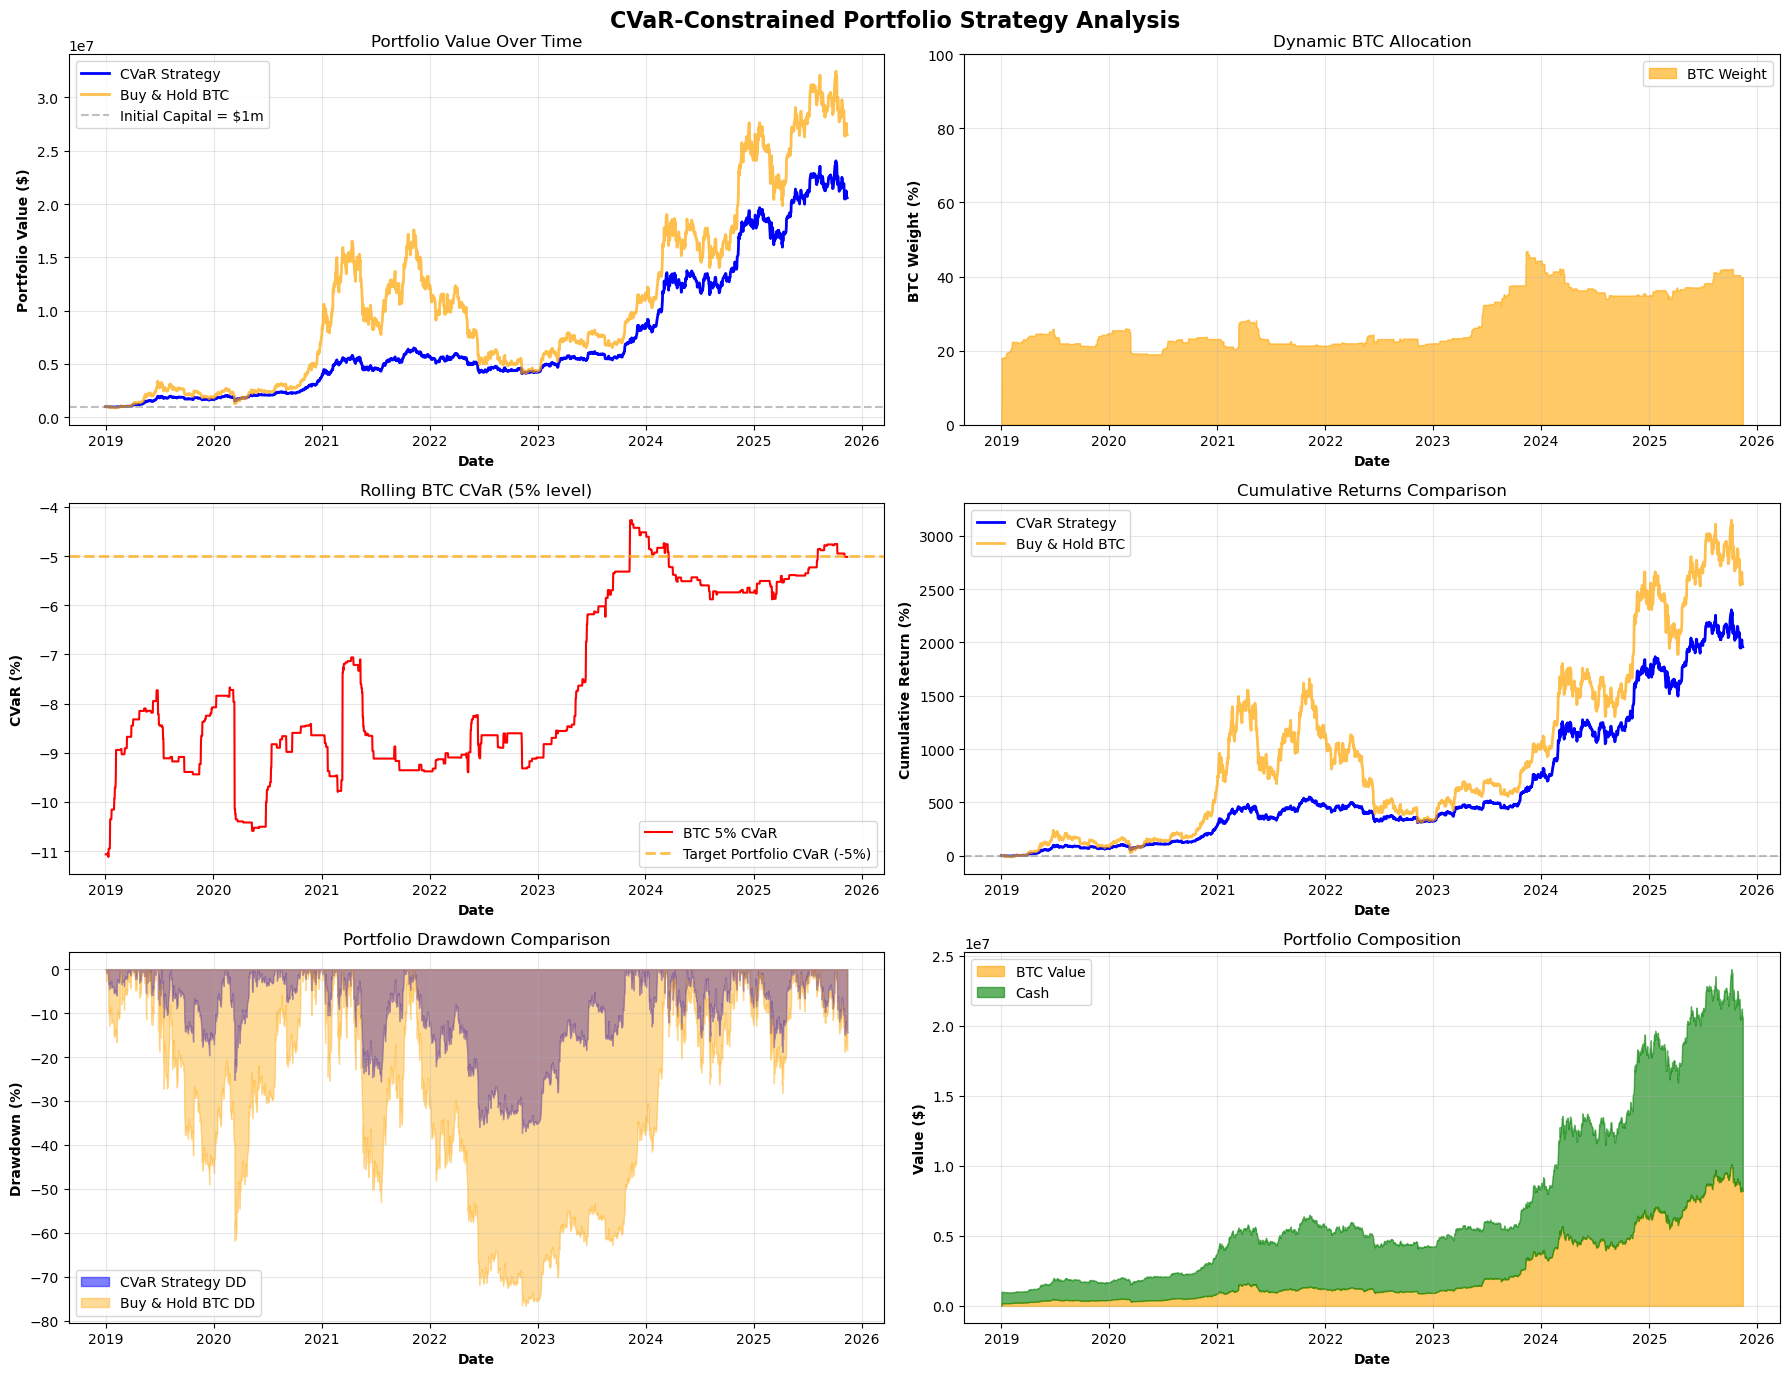

In [ ]:
initial_capital = 1000000
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('CVaR-Constrained Portfolio Strategy Analysis', fontsize=16, fontweight='bold')

# 1. Portfolio Value vs Buy-and-Hold
ax1 = axes[0, 0]
ax1.plot(portfolio_results['Date'], portfolio_results['Portfolio_Value'], 
         label='CVaR Strategy', linewidth=2, color='blue')
ax1.plot(portfolio_results['Date'], 
         initial_capital * (1 + portfolio_results['BTC_Buy_Hold_Return']),
         label='Buy & Hold BTC', linewidth=2, color='orange', alpha=0.7)
ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital = $1m')
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontweight='bold')
ax1.set_title('Portfolio Value Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. BTC Weight Over Time
ax2 = axes[0, 1]
ax2.fill_between(portfolio_results['Date'], 0, portfolio_results['Optimal_Weight']*100,
                 alpha=0.6, color='orange', label='BTC Weight')
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('BTC Weight (%)', fontweight='bold')
ax2.set_title('Dynamic BTC Allocation')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Rolling CVaR of BTC
ax3 = axes[1, 0]
ax3.plot(portfolio_results['Date'], portfolio_results['BTC_CVaR']*100,
         color='red', linewidth=1.5, label='BTC 5% CVaR')
ax3.axhline(-5, color='orange', linestyle='--', linewidth=2, 
            label='Target Portfolio CVaR (-5%)', alpha=0.7)
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('CVaR (%)', fontweight='bold')
ax3.set_title('Rolling BTC CVaR (5% level)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cumulative Returns Comparison
ax4 = axes[1, 1]
ax4.plot(portfolio_results['Date'], portfolio_results['Portfolio_Return']*100,
         label='CVaR Strategy', linewidth=2, color='blue')
ax4.plot(portfolio_results['Date'], portfolio_results['BTC_Buy_Hold_Return']*100,
         label='Buy & Hold BTC', linewidth=2, color='orange', alpha=0.7)
ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Date', fontweight='bold')
ax4.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax4.set_title('Cumulative Returns Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Drawdown Analysis
ax5 = axes[2, 0]

# Calculate CVaR Strategy drawdown
portfolio_cummax = portfolio_results['Portfolio_Value'].cummax()
drawdown_strategy = (portfolio_results['Portfolio_Value'] / portfolio_cummax - 1) * 100

# Calculate Buy & Hold BTC drawdown
btc_values = 100 * (1 + portfolio_results['BTC_Buy_Hold_Return'])
btc_cummax = btc_values.cummax()
drawdown_btc = (btc_values / btc_cummax - 1) * 100

# Plot both drawdowns
ax5.fill_between(portfolio_results['Date'], 0, drawdown_strategy, 
                 color='blue', alpha=0.5, label='CVaR Strategy DD')
ax5.fill_between(portfolio_results['Date'], 0, drawdown_btc,
                 color='orange', alpha=0.4, label='Buy & Hold BTC DD')


ax5.set_xlabel('Date', fontweight='bold')
ax5.set_ylabel('Drawdown (%)', fontweight='bold')
ax5.set_title('Portfolio Drawdown Comparison')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. BTC Value vs Cash
ax6 = axes[2, 1]
ax6.fill_between(portfolio_results['Date'], 0, portfolio_results['BTC_Value'],
                 alpha=0.6, color='orange', label='BTC Value')
ax6.fill_between(portfolio_results['Date'], portfolio_results['BTC_Value'],
                 portfolio_results['Portfolio_Value'],
                 alpha=0.6, color='green', label='Cash')
ax6.set_xlabel('Date', fontweight='bold')
ax6.set_ylabel('Value ($)', fontweight='bold')
ax6.set_title('Portfolio Composition')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
